In [1]:
import pandas as pd

# Load data

In [2]:
df = pd.read_csv('../cleaned_data.csv')

In [3]:
with open('../emojis.txt', 'r') as f:
    emojis = set(f.read())

In [4]:
name_data = pd.read_csv('../name_data.csv', keep_default_na = False).set_index('word').T.to_dict()

In [5]:
user_df = df[[
    'user_name', 'user_screen_name', 'user_statuses_count', 'user_followers_count', 'user_description', 'user_created_at'
]].copy().fillna('')

In [6]:
user_df.sample(n = 10)

,user_name,user_screen_name,user_statuses_count,user_followers_count,user_description,user_created_at
14799,Anne Schnee,anschnee,19848.0,234.0,"Dodger Blue and USC Trojan fan, every day. Reg...",Tue May 05 04:29:41 +0000 2009
54395,FRACT ✊ Your Right To Know !,reinventionfail,46091.0,1074.0,,Sat Apr 21 07:01:35 +0000 2018
10875,🦋 Hira 🦋,hiraamjadx,93655.0,507.0,♡ Tweet tweet ♡,Mon Apr 13 02:11:54 +0000 2015
13253,NeBo,Bo759111Ne,9252.0,220.0,religious with faith in the soul,Sun Jan 29 20:35:52 +0000 2012
40129,Pototo,I_nyctophile,150819.0,2453.0,Self proclaimed pasta connoisseur.🍜🥣\n\n Not ...,Thu Jul 24 18:15:09 +0000 2014
18230,Bolaji Akitikori,Radiopetite,2159.0,285.0,"Daughter, Proofreader, Editor, Speaker, Broadc...",Thu Apr 13 18:36:45 +0000 2017
53794,Chips,Frying_Machine,41638.0,1575.0,#WWG1WGA,Fri Jul 19 20:55:12 +0000 2019
52070,ʸᵃʸᵃᵗ,beycelis,5332.0,111.0,doggos and coffee,Sat Oct 21 17:27:54 +0000 2017
28854,Pedro Serrato III,thrpete21,341.0,148.0,,Wed Feb 06 20:19:07 +0000 2013
42676,pia,Sophiyah_,19934.0,1412.0,"""Was that life? well then, once more!""",Fri Mar 16 10:04:16 +0000 2018


# Get features

In [7]:
from sklearn.model_selection import train_test_split
import re
from collections import Counter
from tqdm import tqdm_notebook as tqdm

In [8]:
name_emoji = user_df.user_name.apply(lambda x: len(set(x) & emojis) > 0)
desc_emoji = user_df.user_description.apply(lambda x: len(set(x) & emojis) > 0).value_counts()

In [9]:
has_emoji = (name_emoji | desc_emoji).astype(int)

In [10]:
has_emoji.head()

0    1
1    1
2    0
3    0
4    0
dtype: int64

In [11]:
created_dates = pd.to_datetime(user_df.user_created_at)

In [12]:
def title_ratio(text):
    words = [w for w in text.split() if re.search('[A-Za-z]', w)]
    return 0 if len(words) == 0 else sum(word.title() == word for word in words) / len(words)
def upper_ratio(text):
    words = [w for w in text.split() if re.search('[A-Za-z]', w)]
    return 0 if len(words) == 0 else sum(word.upper() == word for word in words) / len(words)

In [13]:
def get_n_name(name):
    words = name.split()
    return 0 if len(words) == 0 else sum(
        name_data.get(word.lower(), {}).get('is_name', False)
        for word in words
    )

In [14]:
def get_n_oov(name):
    words = name.split()
    return 0 if len(words) == 0 else sum(
        1-name_data.get(word.lower(), {}).get('in_brown', False)
        for word in words
    )

In [15]:
feature_df = pd.DataFrame({
    'user_name': user_df.user_name,
    'name_normed': user_df.user_name.str.lower().str.replace('[^A-Za-z ]', '').str.replace(' +', ' ').str.strip(),
    'hash_name': user_df.user_name.str.contains('#'),
    'hash_desc': user_df.user_description.str.contains('#'),
    'desc_normed': user_df.user_description.str.lower().str.replace('[^A-Za-z ]', ' ').str.replace(' +', ' ').str.strip(),
    'name_title_ratio': user_df.user_name.apply(title_ratio),
    'name_upper_ratio': user_df.user_name.apply(upper_ratio),
    'desc_title_ratio': user_df.user_description.apply(title_ratio),
    'desc_upper_ratio': user_df.user_description.apply(upper_ratio),
    'age': created_dates.astype(int),
    'empty_desc': user_df.user_description == '',
    'has_emoji': has_emoji,
    'XXX_name': user_df.user_name.str.contains(r'\b[A-Z][A-Z][A-Z]\b'),
    'XX_name': user_df.user_name.str.contains(r'\b[A-Z][A-Z]\b')
})
feature_df['empty_desc_normed'] = feature_df.desc_normed == ''
feature_df['name_nchars'] = feature_df.name_normed.str.len()
feature_df['name_nwords'] = feature_df.name_normed.str.split().str.len()
feature_df['desc_nchars'] = feature_df.desc_normed.str.len()
feature_df['desc_nwords'] = feature_df.desc_normed.str.split().str.len()

feature_df['n_name'] = feature_df.name_normed.apply(get_n_name)
feature_df['name_oov'] = feature_df.name_normed.apply(get_n_oov)
feature_df['desc_oov'] = feature_df.desc_normed.apply(get_n_oov)

feature_df['n_name_ratio'] = (feature_df.n_name / feature_df.name_nwords).fillna(0)
feature_df['name_oov_ratio'] = (feature_df.name_oov / feature_df.name_nwords).fillna(0)
feature_df['desc_oov_ratio'] = (feature_df.desc_oov / feature_df.desc_nwords).fillna(0)

mask = (
    (feature_df.name_normed != '')
)
feature_df = feature_df[mask].copy()

In [16]:
# add features for most common words in names
c = Counter(
    word.lower()
    for name in feature_df.user_name
    for word in name.split()
    if (len(word) > 1)
    and (len(set(word) & emojis) == 0)
    and not name_data.get(word.lower(), {}).get('is_name', False)
)
common_words = [w for w, _ in c.most_common(n = 100)]
for w in tqdm(common_words):
    feature_df[f'name_has_{w}'] = feature_df.user_name.str.lower().str.contains(rf'\b{w}\b')

In [17]:
# add features for most common words in desc
d = Counter(
    word.lower()
    for name in feature_df.desc_normed
    for word in name.split()
    if (len(word) > 1)
)
common_words_desc = [w for w, _ in d.most_common(n = 100)]
for w in tqdm(common_words_desc):
    feature_df[f'desc_has_{w}'] = feature_df.desc_normed.str.lower().str.contains(rf'\b{w}\b')

In [18]:
feature_df.has_emoji.value_counts()

0    80476
1    14749
Name: has_emoji, dtype: int64

In [19]:
feature_df[feature_df.has_emoji == 1].sample(n = 5)

,user_name,name_normed,hash_name,hash_desc,desc_normed,name_title_ratio,name_upper_ratio,desc_title_ratio,desc_upper_ratio,age,...,desc_has_her,desc_has_now,desc_has_country,desc_has_member,desc_has_man,desc_has_retired,desc_has_always,desc_has_pro,desc_has_media,desc_has_mom
12588,kennie morales 🏳️‍🌈❣️✝️🔮,kennie morales,False,False,and living my best life,0.00,0.0,0.000000,0.000000,1470176329000000000,...,False,False,False,False,False,False,False,False,False,False
9170,OneO'ClockDrop 🇺🇸,oneoclockdrop,False,True,monitoring sarscov daily covid the resulting r...,0.00,0.0,0.173913,0.043478,1495814990000000000,...,False,False,False,False,False,False,False,False,False,False
32778,JULIUS OMEKA and 159 Others 🇰🇪,julius omeka and others,False,False,son of the most high making money is an art kn...,0.25,0.5,0.380952,0.000000,1429103921000000000,...,False,False,False,False,False,False,False,False,False,False
56529,Xénianiania ⚔️,xnianiania,False,False,guerri re mytomanique chercheuse de boule de c...,1.00,0.0,0.083333,0.000000,1269707794000000000,...,False,False,False,False,False,False,False,False,False,False
28452,"The Red Wolfe❌ Renegade: God, Country, & Family❌",the red wolfe renegade god country family,False,True,us army army vet america st a a shallnobeinfri...,1.00,0.0,0.526316,0.368421,1573283495000000000,...,False,False,False,False,False,False,False,False,False,False


In [20]:
feature_df[feature_df.has_emoji == 0].sample(n = 5)

,user_name,name_normed,hash_name,hash_desc,desc_normed,name_title_ratio,name_upper_ratio,desc_title_ratio,desc_upper_ratio,age,...,desc_has_her,desc_has_now,desc_has_country,desc_has_member,desc_has_man,desc_has_retired,desc_has_always,desc_has_pro,desc_has_media,desc_has_mom
26727,Abdiasiis Hashi,abdiasiis hashi,False,False,my name abdiasiis and i hope to be a something,1.0,0.0,0.200000,0.000000,1563518577000000000,...,False,False,False,False,False,False,False,False,False,False
12140,Owl,owl,False,False,kita hidup di bumi ini masa depan dengan kapal...,1.0,0.0,0.100000,0.000000,1473512747000000000,...,False,False,False,False,False,False,False,False,False,False
65729,Sonu Handa,sonu handa,False,False,greater hyderabad general secretary national p...,1.0,0.0,0.454545,0.090909,1548167078000000000,...,False,False,False,False,False,False,False,False,False,False
52193,#WWG1WGA,wwgwga,True,True,joined twitter to get the real news maga,0.0,1.0,0.250000,0.125000,1511719133000000000,...,False,False,False,False,False,False,False,False,False,False
30200,Krakkpot,krakkpot,False,False,,1.0,0.0,0.000000,0.000000,1289703658000000000,...,False,False,False,False,False,False,False,False,False,False


In [21]:
n = feature_df.has_emoji.value_counts().min()

In [22]:
balanced_df = pd.concat([
    feature_df[feature_df.has_emoji == 0].sample(n = n),
    feature_df[feature_df.has_emoji == 1].sample(n = n),
])

In [23]:
balanced_df.has_emoji.value_counts()

1    14749
0    14749
Name: has_emoji, dtype: int64

In [24]:
df_train, df_test, has_emoji_train, has_emoji_test = train_test_split(balanced_df, balanced_df.has_emoji, test_size=0.33, stratify = balanced_df.has_emoji)

In [25]:
DROP_COLS = ['user_name', 'name_normed', 'desc_normed', 'has_emoji']
X_train = df_train.drop(columns = DROP_COLS)
X_test = df_test.drop(columns = DROP_COLS)

In [26]:
y_train = has_emoji_train.to_numpy()
y_test = has_emoji_test.to_numpy()

In [27]:
df_train.shape, df_test.shape

((19763, 225), (9735, 225))

# Classify

In [28]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [29]:
clf = RandomForestClassifier(n_estimators = 500, random_state = 0)#max_depth=3, random_state=0)

In [30]:
%time clf.fit(X_train, y_train)

CPU times: user 27.5 s, sys: 529 ms, total: 28 s
Wall time: 28.4 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [31]:
# import numpy as np
# imp = clf.feature_importances_
# q = np.argsort(imp)
# list(reversed([(k, X_train.columns[k], imp[k]) for k in q]))

In [32]:
clf.score(X_test, y_test)

0.7033384694401643

In [33]:
y_pred = clf.predict(X_test)

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.67      0.69      4868
           1       0.69      0.74      0.71      4867

    accuracy                           0.70      9735
   macro avg       0.70      0.70      0.70      9735
weighted avg       0.70      0.70      0.70      9735



In [35]:
scores_test = clf.predict_proba(X_test)[:, 0]

In [36]:
df_test2 = df_test[['user_name', 'desc_normed']].copy()
df_test2['score'] = scores_test

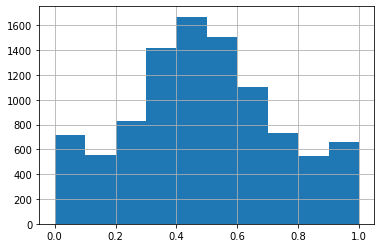

In [37]:
df_test2.score.hist(bins = 10)
plt.show()

In [38]:
df_test2[df_test2.score < 0.2].sample(n = 10)

,user_name,desc_normed,score
58011,tuphe,,0.100
60839,J❣️,,0.096
68333,Barney_Cannon 🧢🇺🇸 💯,if you voted republican or rd party in you sha...,0.104
28859,Thomas Austin 🇪🇺#FBPD -S.V.B.E.E.V.-,for my sins i mostly comment btl in the guardi...,0.014
41384,xabbiewoodx,,0.158
71989,Joe,,0.082
29455,works,,0.130
79574,Prity Dubay 💯Follow Back💯,https t co orfie birr,0.130
87768,A Mallu SidHeart❤,am lekshmy only here for sidharth shukla die h...,0.166
94206,🦅Deplorable ER RN,prolife er rn wife of army vet ret deputy mom ...,0.006


In [39]:
df_test2[df_test2.score > 0.8].sample(n = 10)

,user_name,desc_normed,score
42087,Tom Mitchell,,0.970
89957,Rafey Haider,progressive values zindabad,0.822
18862,शशांक अम्बादे-shashank ambade,,0.892
24091,Anne Clare Jones,strong believer in the common good registered ...,0.824
7990,Rebecca Sills,i am an massive manchester united fan and my f...,0.946
5656,RC Bot,twitter bot for promoting daysofcode campaign ...,0.902
7190,Britta Swenson,independent minnesotan midwestern evangelical ...,0.818
28311,Laurie Fare,,0.968
10104,🇺🇸 Elections Matter 🇺🇸,,0.906
43629,"Debajyoti Majumder, Dean-Aakash Institute-WB,B...",years of rich experience in learning and devel...,0.808


In [40]:
df_test2[df_test2.user_name.str.contains('News')].sort_values(by = 'score')

,user_name,desc_normed,score
85186,ChiHouston News Bench™,anti left since recovering journalist ex acu a...,0.000
31041,ChiHouston News Bench™,anti left since recovering journalist ex acu a...,0.000
94227,ChiHouston News Bench™,anti left since recovering journalist ex acu a...,0.000
90862,Pune News & Retweets | 🚫 | 😷 | 👐🏻 | 🧼,staysafe getwellsoon pune maharashtra rt from ...,0.196
97291,Pune News & Retweets | 🚫 | 😷 | 👐🏻 | 🧼,staysafe getwellsoon pune maharashtra rt from ...,0.196
92017,Pune News & Retweets | 🚫 | 😷 | 👐🏻 | 🧼,staysafe getwellsoon pune maharashtra rt from ...,0.196
51597,Harrogate EV News ❤🌍♻🔋🚗🚌✈,low zero carbon circular economy ev smart home...,0.398
48792,Kat Godspell News & Comment 🌹🍑🆘 🧙‍♀️,retired rn demsocialists resist ourrevolution ...,0.420
68211,Deep News-Multipolar,intelligence strategy international relations ...,0.442
20512,dTradrNewsXR🧢,news n stuff world financial markets stocks cu...,0.482


# Results on full dataset

In [41]:
X = feature_df.drop(columns = DROP_COLS)
y = feature_df.has_emoji

In [42]:
clf.score(X, y)

0.7425045943817274

In [43]:
%time y_pred = clf.predict(X)

CPU times: user 15.8 s, sys: 204 ms, total: 16 s
Wall time: 16 s


In [44]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.71      0.82     80476
           1       0.37      0.91      0.52     14749

    accuracy                           0.74     95225
   macro avg       0.67      0.81      0.67     95225
weighted avg       0.88      0.74      0.78     95225



In [45]:
%time scores = clf.predict_proba(X)[:, 0]

CPU times: user 15.5 s, sys: 184 ms, total: 15.7 s
Wall time: 15.7 s


In [46]:
df.shape

(100325, 14)

(array([ 4212.,  5791.,  5646.,  8734., 12322., 13147., 11440., 10692.,
        11205., 12036.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

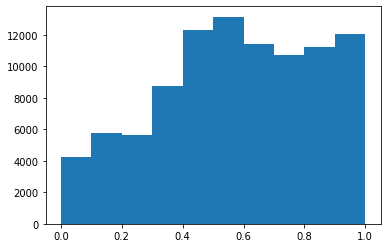

In [47]:
plt.hist(scores)

In [48]:
df2 = feature_df[[
    'user_name', 'desc_normed'
]].copy()
df2['score'] = scores

In [49]:
df2[df2.score < 0.2].sample(n = 10)

,user_name,desc_normed,score
69871,A L E 🐾,sac libra welcome to my fucked up mind not for...,0.026
35058,Be Epic • Minnillo,myp i s teacher using twitter to inform educat...,0.134
69977,!BLVCK👑,blvcklover mufc black ain t sad book lover novels,0.002
12981,The Kisii Princess 🇰🇪,a beautiful village woman,0.000
64984,KnightYellowVest ⭐⭐⭐,make the world great again qanon q patriot mag...,0.108
40739,Job_TheMan 👑,bsc physiology biochemistry graduate bsc physi...,0.068
28838,#HelpTheMostVulnerable,advocateforthedisabled animalrights lovemycoun...,0.192
67321,!BLVCK👑,blvcklover mufc black ain t sad book lover novels,0.002
89496,Govinda Verma 👤,,0.128
51372,😷HEDG€FUND📈$TRAT£G¥,globaltradingstratgymap returns conferncs earn...,0.138


In [50]:
df2[df2.score > 0.8].sample(n = 10)

,user_name,desc_normed,score
1966,Mahi,nithiin cult dhoni,0.890
84185,Mnqobi Ndimande,i loooooove jesus i can do all things through ...,0.886
95794,Seth Jones,em resident global health social justice,0.842
41582,Sheru @58,,0.952
79314,deepak,,0.922
88550,Risky Liberal,this is going to end with stephen miller kelly...,0.850
27697,Arun dogra,,0.996
1950,ROB Bhopal,official account of the regional outreach bure...,0.870
45376,Nicola Di Paola,,0.922
61711,azeem ahmad,,0.994


In [108]:
non_name_words = {w for w in name_data if not name_data[w]['is_name']}
name_words = {w for w in name_data if name_data[w]['is_name']}

In [140]:
df2[
    (df2.score > 0.6)
    & df2.user_name.apply(lambda x: len(set(x.lower().split()) & non_name_words) > 0)
    & df2.user_name.apply(lambda x: len(set(x.lower().split()) & name_words) == 0)
    & df2.user_name.apply(lambda x: not any(len(w) == 1 for w in x.split()))
    & df2.user_name.str.lower().str.replace(r'\.', '').str.split().apply(
        lambda x: len(set(x) & {'dr', 'mr', 'ms', 'mrs'}) == 0
     )
].sample(n = 10)

,user_name,desc_normed,score
90294,Information world,,0.766
56832,Bini,,0.888
4960,Coronavirus Live,coronavirus realtime global statistics data fr...,0.864
79640,Idiopathic Doctor,orthopaedics politics bollywood cricket humour...,0.750
35225,Save Gloucester,community based organisation dedicated to pres...,0.686
28233,Perpetual Traveller,sovereign society,0.692
49683,Fuad Farouk,live slow die whenever,0.626
51105,OKWUTE FOTOS GLOBAL,i can do all things,0.782
36726,Rodolfo Alas Lao,the key to immortality is first living a life ...,0.672
6822,book lover,,0.920


In [145]:
df2[~(
        (df2.score > 0.6)
    & df2.user_name.apply(lambda x: len(set(x.lower().split()) & non_name_words) > 0)
    & df2.user_name.apply(lambda x: len(set(x.lower().split()) & name_words) == 0)
    & df2.user_name.apply(lambda x: not any(len(w) == 1 for w in x.split()))
    & df2.user_name.str.lower().str.replace(r'\.', '').str.split().apply(
        lambda x: len(set(x) & {'dr', 'mr', 'ms', 'mrs'}) == 0
     )
)].sample(n = 10)

,user_name,desc_normed,score
12416,Najla Daher,health management policy aub,0.822
89499,Meenakshi Priyam,human resources explorer views are my own,0.582
34885,pre-Virgin BoY,networking expert rabbit farmer yoruba boy,0.432
47925,Sherry Moran,retired and happy citizen advocate with result...,0.704
100246,jenjenk,eater traveler picture taker and a voracious d...,0.846
51378,Augustine,,0.302
58974,CoolchixNZ,here to follow and support my queen taylorswif...,0.454
33620,Ayat Raza Khan,haddiyan todne me wo maza nahi hai jo dushman ...,0.844
21748,Carolyn Smith,connector netweaver for inspiration wisdom hea...,0.736
25945,Mehboob Hindi,mehboob hindi,0.998


In [100]:
df2[df2.user_name.str.contains('Time')]

,user_name,desc_normed,score
441,The Times of India,news views analysis conversations india s no d...,0.996
1555,⚕ Big Time Heart ⚕,i have marfan syndrome a rare genetic disorder...,0.570
1605,The Times of India,news views analysis conversations india s no d...,0.996
1607,The Times of India,news views analysis conversations india s no d...,0.996
1934,The Times of India,news views analysis conversations india s no d...,0.996
2087,The Times of India,news views analysis conversations india s no d...,0.996
2317,The Times of India,news views analysis conversations india s no d...,0.996
2730,Calcutta Times,official handle of calcutta times,0.674
2801,The Times of India,news views analysis conversations india s no d...,0.996
3084,The Times of India,news views analysis conversations india s no d...,0.996


# Save model

In [86]:
import pickle

In [94]:
with open('../formality_features.txt', 'w') as f:
    f.write('\n'.join(X_train.columns))

In [87]:
with open('../formality_model.p', 'wb') as f:
    f.write(pickle.dumps(clf))

In [88]:
with open('../common_name_words.txt', 'w') as f:
    f.write('\n'.join(common_words))

In [89]:
with open('../common_desc_words.txt', 'w') as f:
    f.write('\n'.join(common_words_desc))